In [22]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

In [23]:
# fixes skew on one locator box only??
def fix_locator_box_skew(image):
    # Apply edge detection to find contours
    edges = cv2.Canny(image, 50, 150, apertureSize=5)
    contours, _ = cv2.findContours(edges, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    # Find the largest contour (assumed to be the QR code)
    max_contour = max(contours, key=cv2.contourArea)

    # Approximate the polygonal curve of the contour
    epsilon = 0.02 * cv2.arcLength(max_contour, True)
    approx = cv2.approxPolyDP(max_contour, epsilon, True)

    # Check if the contour is a quadrilateral (4 vertices)
    if len(approx) == 4:
        # Reshape the vertices of the quadrilateral
        rect = np.zeros((4, 2), dtype=np.float32)
        for i in range(4):
            rect[i] = approx[i][0]
        # print(rect)

        # Calculate angles of the lines forming the sides of the locator box
        angles = []
        for i in range(4):
            p1 = rect[i]
            p2 = rect[(i + 1) % 4]
            p3 = rect[(i + 2) % 4]
            v1 = p1 - p2
            v2 = p3 - p2
            angle = np.degrees(
                np.arccos(np.dot(v1, v2) / (np.linalg.norm(v1) * np.linalg.norm(v2)))
            )
            angles.append(angle)

        # Check if any angle deviates significantly from 90 degrees
        if any(abs(angle - 90) > 10 for angle in angles):
            # Compute the target square shape
            target_shape = np.array(
                [[0, 0], [1012, 0], [1012, 1012], [0, 1012]], dtype=np.float32
            )

            # Compute the perspective transformation matrix
            matrix = cv2.getPerspectiveTransform(rect, target_shape)

            # Apply the perspective transformation to correct skew
            corrected_image = cv2.warpPerspective(image, matrix, (1012, 1012))
            return corrected_image

    # Return the original image if no skew is detected or contour is not a quadrilateral
    return image

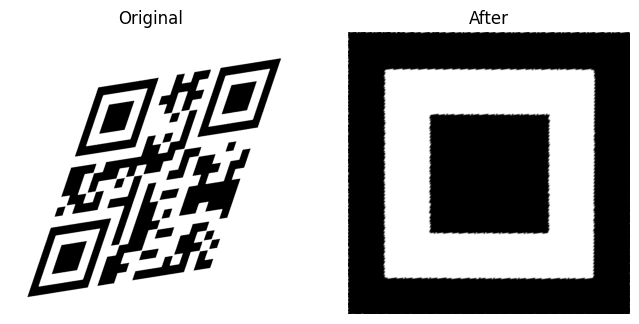

In [24]:
test_case = "test_data/6_railfence_cipher.png"
img = cv2.imread(test_case, 0)
original_img = img.copy()

img = cv2.equalizeHist(img)
_, img = cv2.threshold(img, 0, 255, cv2.THRESH_BINARY)
img_new = fix_locator_box_skew(img)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.axis("off")
plt.imshow(img, cmap="gray")
plt.title("Original")

plt.subplot(1, 2, 2)
plt.axis("off")
plt.imshow(img_new, cmap="gray")
plt.title("After")

plt.show()